In [1]:
import sys
import pandas as pd
import numpy as np
sys.path.append('../ABM_SDMs')

from trainer import SDMsTrainer

%load_ext autoreload
%autoreload 2

INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


## SDM vanilla

In [2]:
model_name = "SDM_vanilla"
inference_vars = ["c", "kappa"]
param_names=["cc", "kappakappa"]
summary_vars = ["point", "memory_items"]

SDM_trainer = SDMsTrainer(
    model_name=model_name,
    sdm_simulator_kwargs = dict(
        param_keys=inference_vars,
        param_names=param_names,
        data_cols = summary_vars
    )
)

Findg default prior and batch simulator for model: SDM_vanilla
Self Simulation Check complete!
Checkpoint path not provided, using default: ..\checkpoints\SDM_vanilla
Loading pretrained weights from: ..\checkpoints\SDM_vanilla\SDM_vanilla.keras


### loading fitting resluts from bmm

In [ ]:
import h5py

# Open the HDF5 file in read mode
with h5py.File('SDMrecovery.h5', 'r') as f:
    # Print available keys in the file (optional, for inspection)
    print("Keys in the file: %s" % list(f.keys()))

    # Read the 'simulatedData' dataset from the 'Data' group and convert to DataFrame
    # The data was saved with structure, so it reads as a structured numpy array which converts directly to a DataFrame
    df_simulated_data = pd.DataFrame(f['Data/simulatedData'][:])

    # Read the 'TrueLogParms' dataset from the 'True' group and convert to DataFrame
    df_true_log_parms = pd.DataFrame(f['True/TrueLogParms'][:])

    # Read the 'logposteriors' dataset from the 'Posterior' group and convert to DataFrame
    df_log_posteriors = pd.DataFrame(f['Posterior/logposteriors'][:])

Keys in the file: ['Data', 'Posterior', 'True']


In [4]:
def extract_posterior_means(df_log_posteriors):
    """
    Extract mean values of 'c' and 'kappa' parameters from log posteriors DataFrame
    and create a new DataFrame with repeated mean values to reach target length.
    
    Parameters:
    -----------
    df_log_posteriors : pandas.DataFrame
        DataFrame containing log posterior values with columns named like 'c[*]' and 'kappa[*]'
    target_length : int, default=200
        Target length for the output DataFrame
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with two columns:
        - 'c_mean': mean values of c parameters repeated to target length
        - 'kappa_mean': mean values of kappa parameters repeated to target length
    """
    # Extract columns related to 'c' and 'kappa' parameters
    c_data = df_log_posteriors[[col for col in df_log_posteriors.columns if 'c[' in col]]
    kappa_data = df_log_posteriors[[col for col in df_log_posteriors.columns if 'kappa[' in col]]
    
    # Create new DataFrame with repeated mean values to reach target length
    df_posterior_bmm = pd.concat(
        [
            c_data.mean(axis=0).reset_index().set_axis(['c_index', 'c_mean'], axis=1), 
            kappa_data.mean(axis=0).reset_index().set_axis(['kappa_index', 'kappa_mean'], axis=1)
        ], 
        axis=1)
    
    return df_posterior_bmm

df_posterior_bmm = extract_posterior_means(df_log_posteriors)
df_prior_bmm = df_true_log_parms.T.set_axis(['c_mean', 'kappa_mean'], axis=1)

### fitting data by bayesflow

In [5]:
df_simulated_data["response"] = np.degrees(df_simulated_data["response"])
fitting_data_dict = SDM_trainer.prepare_fitting_data(df_simulated_data, response_arc_col=None,id_col="id", response_point_col="response")

In [6]:
df_posterior_bayesflow = SDM_trainer.fitting_data_summary(fitting_data_dict, preprocess_data=False)

### plot

In [7]:
def plot_parameter_correlation(df1, df2, xlabel="prior", ylabel="posterior", figsize_per_subplot=(6, 5)):
    """
    Create scatter plots with linear regression lines for common parameters between two DataFrames.

    Parameters:
    -----------
    df1 : pandas.DataFrame
        First DataFrame containing parameter estimates with columns like 'c_mean', 'kappa_mean', etc.
    df2 : pandas.DataFrame
        Second DataFrame containing parameter estimates with columns like 'c_mean', 'kappa_mean', etc.
    figsize_per_subplot : tuple, optional
        Figure size for each subplot, default is (6, 5)

    Returns:
    --------
    matplotlib.figure.Figure
        The figure containing all correlation plots
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Find common columns between the two DataFrames
    common_columns = list(set(df1.columns) & set(df2.columns))
    
    if not common_columns:
        print("No common columns found between the two DataFrames.")
        return None
    
    # Calculate number of subplots needed
    n_params = len(common_columns)
    n_cols = 2  # Number of columns in the subplot grid
    n_rows = int(np.ceil(n_params / n_cols))
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_subplot[0] * n_cols, 
                                                      figsize_per_subplot[1] * n_rows))
    
    # Handle case where there's only one subplot
    if n_params == 1:
        axes = [axes]
    elif n_params == 2:
        axes = axes.flatten()
    else:
        axes = axes.flatten() if n_rows * n_cols > 1 else [axes]
    
    # Create correlation plots for each common parameter
    for i, param in enumerate(common_columns):
        ax = axes[i]
        
        # Prepare data for plotting
        data_to_plot = pd.DataFrame({
            f'{param}_x': df1[param].values,
            f'{param}_y': df2[param].values
        })
        
        # Create scatter plot with regression line using seaborn
        sns.regplot(data=data_to_plot, 
                   x=f'{param}_x', 
                   y=f'{param}_y', 
                   ax=ax, 
                   scatter_kws={'alpha': 0.6})
        
        # Add title and labels
        ax.set_title(f'Correlation: {param}')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Add correlation coefficient to the plot
        corr_coef = data_to_plot[f'{param}_x'].corr(data_to_plot[f'{param}_y'])
        ax.text(0.05, 0.95, f'r = {corr_coef:.3f}', 
                transform=ax.transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Hide empty subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    return fig

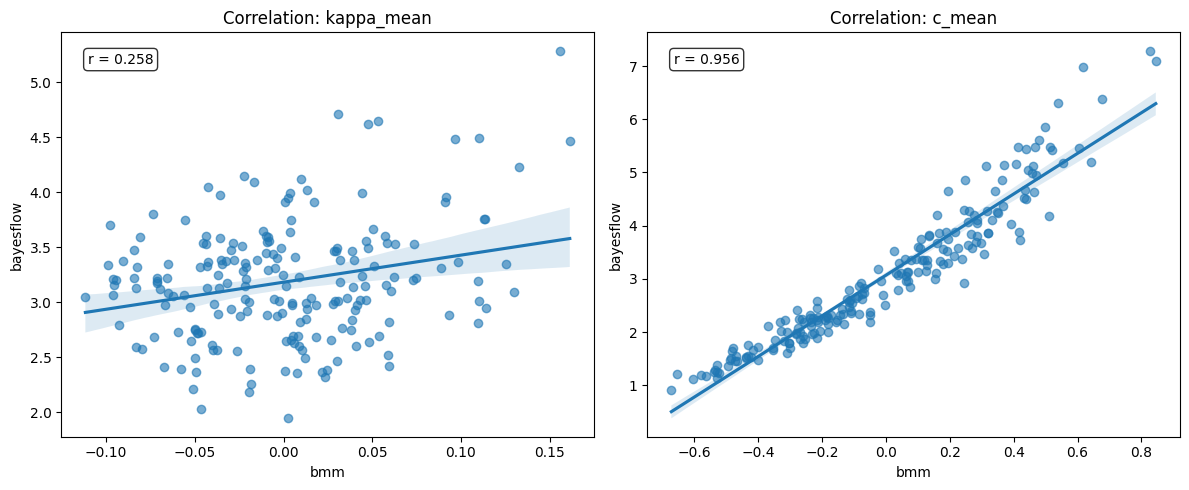

In [8]:
fig = plot_parameter_correlation(df_posterior_bmm, df_posterior_bayesflow, "bmm", "bayesflow")

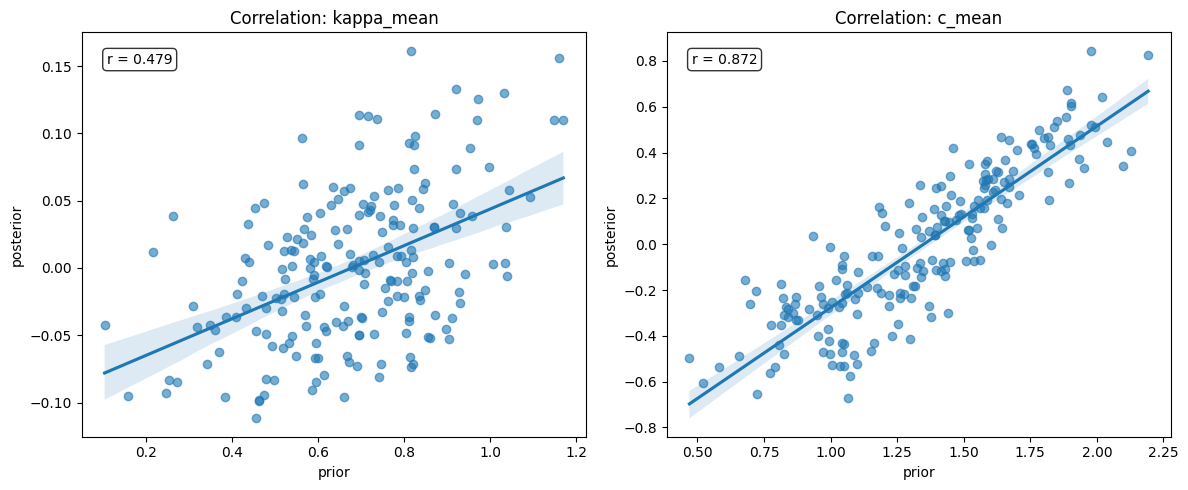

In [9]:
fig = plot_parameter_correlation(df_prior_bmm, df_posterior_bmm)

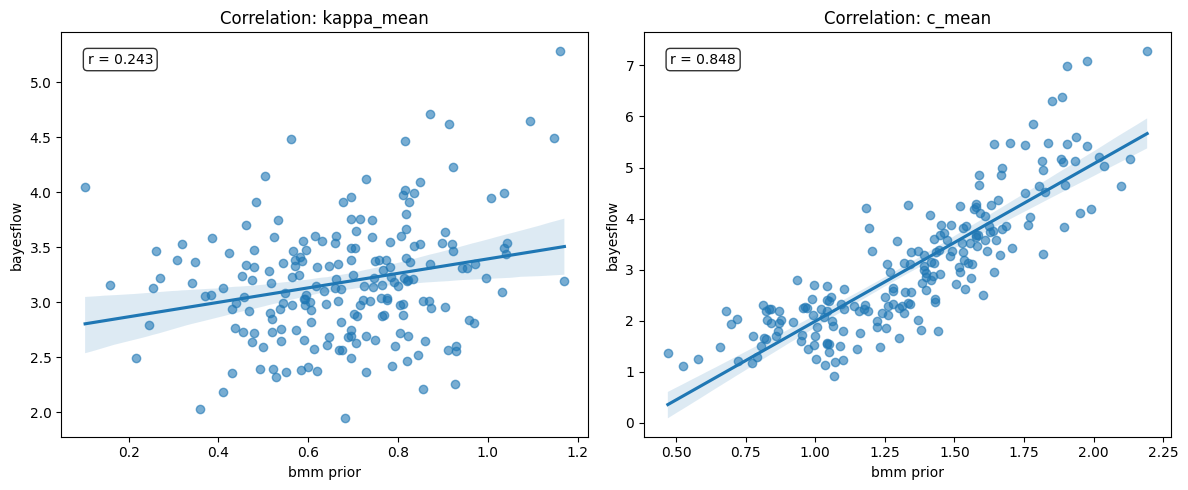

In [10]:
fig = plot_parameter_correlation(df_prior_bmm, df_posterior_bayesflow, "bmm prior", "bayesflow")